In [12]:
import os
from glob import glob
from PIL import Image
import numpy as np
import anndata
from dataset import HERDataset
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
from utils import get_R, cluster
import pandas as pd
import scanpy as sc

In [13]:
names = os.listdir(r"D:\dataset\Her2st\data/ST-cnts")
names.sort()
names = [i[:2] for i in names][1:33]
gene_list_path = "D:\dataset\Her2st\data/her_hvg_cut_1000.npy"
gene_list = list(np.load(gene_list_path, allow_pickle=True))

Loading imgs ...
Loading metadata...
Loading imgs ...
Loading metadata...
Loading imgs ...
Loading metadata...
Loading imgs ...
Loading metadata...
Loading imgs ...
Loading metadata...
Loading imgs ...
Loading metadata...
Loading imgs ...
Loading metadata...
Loading imgs ...
Loading metadata...
Loading imgs ...
Loading metadata...
Loading imgs ...
Loading metadata...
Loading imgs ...
Loading metadata...
Loading imgs ...
Loading metadata...
Loading imgs ...
Loading metadata...
Loading imgs ...
Loading metadata...
Loading imgs ...
Loading metadata...
Loading imgs ...
Loading metadata...
Loading imgs ...
Loading metadata...
Loading imgs ...
Loading metadata...
Loading imgs ...
Loading metadata...
Loading imgs ...
Loading metadata...
Loading imgs ...
Loading metadata...
Loading imgs ...
Loading metadata...
Loading imgs ...
Loading metadata...
Loading imgs ...
Loading metadata...
Loading imgs ...
Loading metadata...
Loading imgs ...
Loading metadata...
Loading imgs ...
Loading metadata...
L

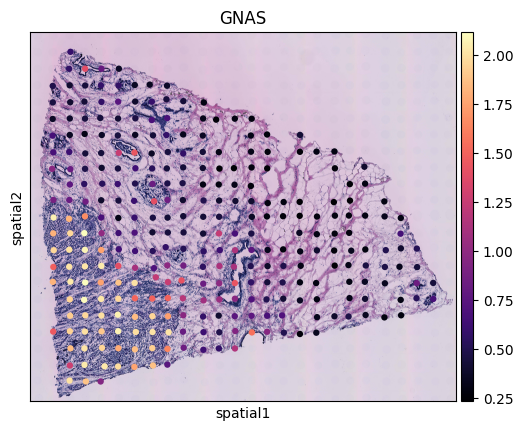

Loading imgs ...
Loading metadata...
Gene: FN1, Max -log(p-value) in B6: 66.49574990411878, PCC in B6: 0.8153348082173453


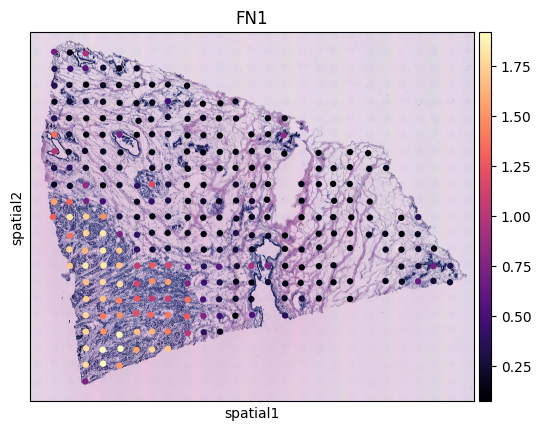

Loading imgs ...
Loading metadata...
Gene: FASN, Max -log(p-value) in B2: 55.673117428464344, PCC in B2: 0.7796053276935957


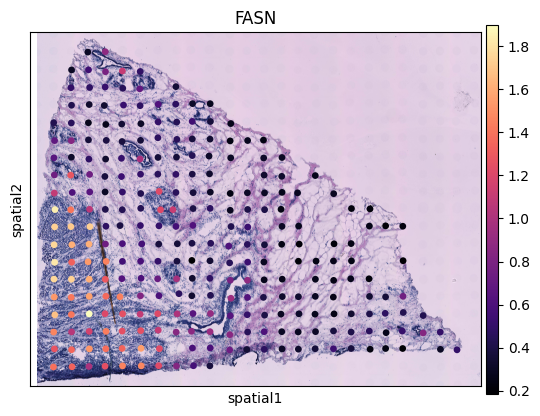

Loading imgs ...
Loading metadata...
Gene: HLA-B, Max -log(p-value) in B4: 77.31367757650334, PCC in B4: 0.8441040802323344


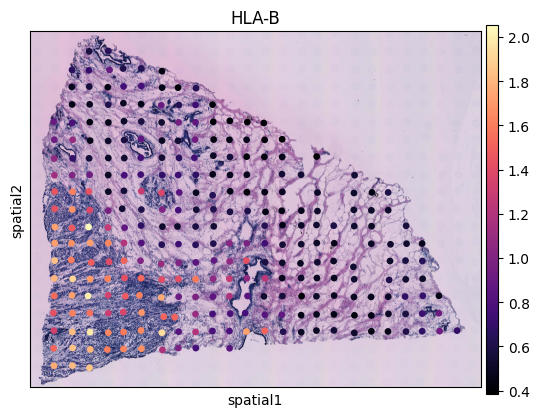

Loading imgs ...
Loading metadata...
Gene: SCD, Max -log(p-value) in B6: 64.41835778562279, PCC in B6: 0.8080384061967886


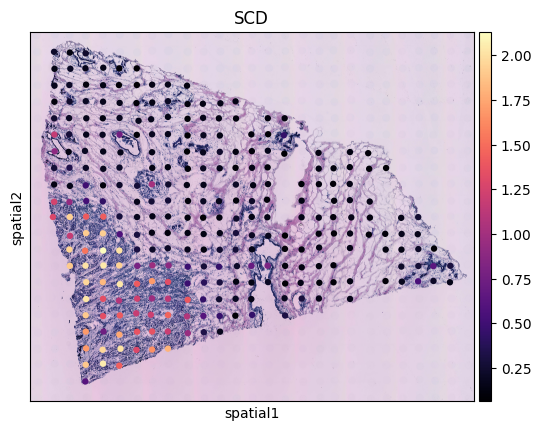

Loading imgs ...
Loading metadata...
Gene: IGKC, Max -log(p-value) in F2: 77.09680819723347, PCC in F2: 0.6289915275636789


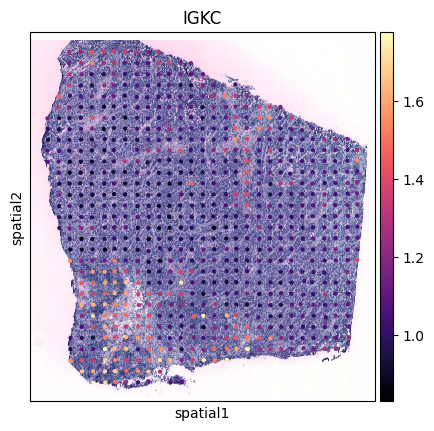

Loading imgs ...
Loading metadata...
Gene: HLA-DRA, Max -log(p-value) in B6: 71.83510752988644, PCC in B6: 0.8327048138938901


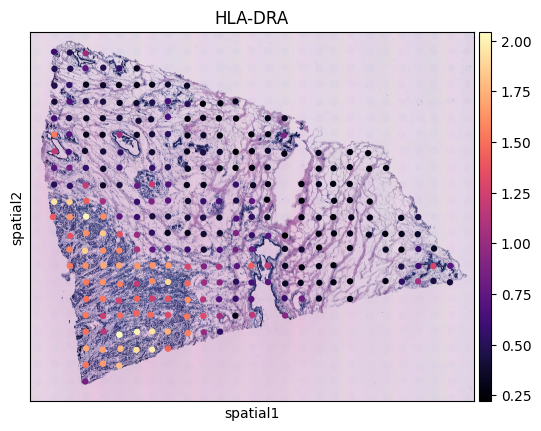

In [14]:
result_df = pd.DataFrame(index=gene_list, columns=names)
for fold, name in enumerate(names):
    ture = np.load(f"./data/preprocessed_expression_matrices/her2st/{name}/preprocessed_matrix.npy")
    pred = np.load(f'./her2st_pred_att/{name}/matched_spot_expression_pred_mclSTExp.npy')

    adata_ture = anndata.AnnData(ture.T)
    adata_pred = anndata.AnnData(pred.T)


    adata_pred.var_names = gene_list
    adata_ture.var_names = gene_list

    test_dataset = HERDataset(train=False, fold=fold)
    ct = test_dataset.center_dict[name]
    adata_pred.obsm['spatial'] = ct
    adata_ture.obsm['spatial'] = ct
    
    pcc, p = get_R(adata_pred, adata_ture)
    adata_pred.var["pcc"] = pcc
    adata_pred.var["-log10p_val"] = -np.log10(p)
    pcc_list, p_value_list = get_R(adata_pred, adata_ture)
    result_df[name] = -np.log10(p_value_list)


result_df['avg_p_value'] = result_df.mean(axis=1)
sorted_result_df = result_df.sort_values(by='avg_p_value', ascending=False)


# csv_output_path = "sorted_result_mclSTExp.csv"
# sorted_result_df.to_csv(csv_output_path)
top_7_records = sorted_result_df.head(7)
for gene, row in top_7_records.iterrows():
    max_p_value_slice = row.idxmax()
    max_p_value = row[max_p_value_slice]

    ture = np.load(f"./data/preprocessed_expression_matrices/her2st/{max_p_value_slice}/preprocessed_matrix.npy")
    pred = np.load(f'./her2st_pred_att/{max_p_value_slice}/matched_spot_expression_pred_mclSTExp.npy')

    adata_ture = sc.AnnData(ture.T)
    adata_pred = sc.AnnData(pred.T)

    adata_pred.var_names = gene_list
    adata_ture.var_names = gene_list

    for i in range(len(names)):
        if names[i] == max_p_value_slice:
            test_dataset = HERDataset(train=False, fold=i)
            ct = test_dataset.center_dict[max_p_value_slice]
            adata_pred.obsm['spatial'] = ct
            adata_ture.obsm['spatial'] = ct

    pcc, _ = get_R(adata_pred, adata_ture)
    samps = -1
    for i in range(len(gene_list)):
        if gene_list[i] == gene:
            samps = i
            print(
                f"Gene: {gene}, Max -log(p-value) in {max_p_value_slice}: {max_p_value}, PCC in {max_p_value_slice}: {pcc[i]}")
    img = f"D:\dataset\Her2st\data\ST-imgs\{max_p_value_slice[0]}\{max_p_value_slice}/"
    image_paths = glob(os.path.join(img, '*.jpg'))[0]
    image = Image.open(image_paths)
    image_array = np.array(image)

    sc.pl.spatial(adata_pred, img=image_array, color=gene_list[samps], spot_size=112, color_map='magma')
    # plt.savefig(
    #     rf"C:\Users\DELL\Desktop\mclSTExp_attention\MS\Figtures\Ours_Fig5/{gene_list[samps]}_pred_pcc_{'%.3f' % pcc[samps]}.pdf",
    #     format="pdf", bbox_inches="tight")
    # plt.show()
    # sc.pl.spatial(adata_ture, img=image_array, color=gene_list[samps], spot_size=112, color_map='magma', show=False)
    # plt.savefig(rf"C:\Users\DELL\Desktop\mclSTExp_attention\MS\Figtures\Fig5/{gene_list[samps]}_ture.pdf", format="pdf", bbox_inches="tight")
    # plt.show()

In [17]:
from torch.utils.data import DataLoader

name = "B1"  #B1 C1 D1 E1 F1 G2
fold = 5 #5 11 17 23 26 30
pred = np.load(f'./her2st_pred/{name}/matched_spot_expression_pred.npy')
test_dataset = HERDataset(train=False, fold=fold)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)
print("[test_dataset.names[0]]", [test_dataset.id2name[0]])
label = test_dataset.label[name]
exp = test_dataset.exp_dict[name]
adata_ture = anndata.AnnData(exp)
adata_pred = anndata.AnnData(pred.T)
adata_ture.var_names = gene_list
adata_pred.var_names = gene_list

ct = test_dataset.center_dict[name]

adata_pred.obsm['spatial'] = ct
adata_ture.obsm['spatial'] = ct

p, ari, nmi = cluster(adata_pred, label)
print(f"ARI: {ari}, NMI: {nmi}")

Loading imgs ...
Loading metadata...
[test_dataset.names[0]] ['B1']
ARI: 0.381, NMI: 0.429


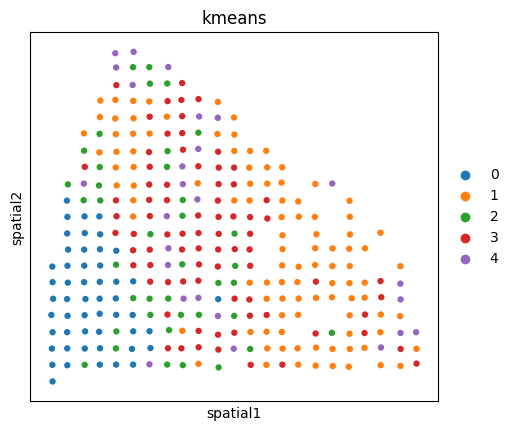

In [18]:
sc.pl.spatial(adata_pred, img=None, color='kmeans', spot_size=112)